# Toxic Comments Classification 96.8% Accuracy Solution - Kaggle Competition

In this notebook I'll be compleating the kaggle challenge listed here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data <br> This challenge is a multi label classifcation problem where I must return the probability of each of the labels: toxic, severe_toxic, obscene,threat,insult,identity_hate

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import pickle
import numpy as np
import nltk
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from time import time
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


try:    
    from google.colab import files
    colab = True  
except:
    colab = False
if colab:
    import zipfile

[nltk_data] Downloading package punkt to /home/tyler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tyler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tyler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#if in colab env upload a zip file and extract data to save time.
if colab:
    files = files.upload()
    zip_ref = zipfile.ZipFile('data.zip', 'r')
    zip_ref.extractall('./')
    zip_ref.close()
    print(os.listdir())
    train_data = pd.read_csv('./data/train.csv')
    test_data = pd.read_csv('./data/test.csv')
else:  
    train_data = pd.read_csv('./data/train.csv')
    test_data = pd.read_csv('./data/test.csv')




## Step 1: Analize Data

([array([144277.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  15294.]),
  array([157976.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,   1595.]),
  array([151122.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,   8449.]),
  array([159093.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,    478.]),
  array([151694.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,   7877.]),
  array([158166.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,   1405.])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 6 Lists of Patches objects>)

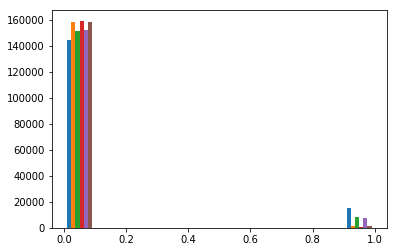

In [3]:
plt.hist([train_data['toxic'], train_data['severe_toxic'],train_data['obscene'], train_data['threat'], train_data['insult'], train_data['identity_hate']])

The data is skewed to non negitive comments (left bars). 10% of the rows in the training data contain some sort of negitivity. We're going to need to seperate the data evenly to avoid bias toward non negative comments (right bars).



In [30]:
def distribute_data(train_data):
    negative_rows = []
    positive_rows = []
    for comment, toxic, severe_toxic, obscene, threat, insult, identity_hate in zip(train_data['comment_text'],train_data['toxic'],train_data['severe_toxic'], train_data['obscene'], train_data['threat'], train_data['insult'], train_data['identity_hate']):
        #check for some sort of negitivity in columns
        if toxic == severe_toxic == obscene == threat == insult == identity_hate:
            positive_rows.append([comment, toxic, severe_toxic, obscene, threat, insult, identity_hate])
        else:
            negative_rows.append([comment, toxic, severe_toxic, obscene, threat, insult, identity_hate])




    #shuffle positive rows
    random.shuffle(positive_rows)
    #grab sample size of positive comments = to the total amount of negitive comments
    positive_rows = positive_rows[:len(negative_rows)]
    #combne them into a single list
    combine = negative_rows + positive_rows
    #shuffle
    random.shuffle(combine)
    train_data = combine
    return train_data


## Step 2: Preprocess Data

1. distribute training data evenly between negitive sentiment and non negitive sentiment to avoid bias <br>
2. remove all non alphabetic characters. <br>
3. Tokenize string into an list EX: "Machine learning is fun" -> ["Machine ,"learning", "is", "fun"] <br>
4. Filter stopwords out (commonly used words EX: "The") <br>
5. lemmatizing words (converting a word to its base form) EX: Caring -> Lemmatization -> Care <br>

In [5]:
train_data = distribute_data(train_data)

In [6]:
def preprocess_train(data):
    labels = []
    comments = []   
    stop_words =  set(stopwords.words('english'))       
    lemmatizer = WordNetLemmatizer()
    #evens out training data to avoid bias    
    #preprocess
    for line in data:      
        line[0] = re.sub('[^A-Za-z\s]+',  '',line[0])
        word_tokens = word_tokenize(line[0])  
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        processed = " ".join([lemmatizer.lemmatize(w) for w in filtered_sentence]).lower()
        comments.append(processed)
        labels.append(line[1:])
    return comments,labels
   
        

In [7]:
def preprocess_test(data):
     
    comments = []
    stop_words =  set(stopwords.words('english'))       
    lemmatizer = WordNetLemmatizer() 
    for line in data['comment_text']:   
        line = re.sub('[^A-Za-z\s]+',  '',line)       
        word_tokens = word_tokenize(line)  
        filtered_sentence = [w for w in word_tokens if not w in stop_words]        
        processed = " ".join([lemmatizer.lemmatize(w) for w in filtered_sentence]).lower()
        comments.append(processed)           
    return comments

In [8]:
X_train ,y_train = preprocess_train(train_data)

In [9]:
X_test = preprocess_test(test_data)


In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)

(32388,)
(153164,)


Our neural net only understands numbers. Hence we need to transform our words into vector representations.

We fit <strong>ONLY</strong> on training set and then call texts_to_sequences on both train and test set to transform them.

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


Deep learning libraries assume a vectorized representation of your data.

In the case of variable length sequence prediction problems, this requires that your data be transformed such that each sequence has the same length.

This vectorization allows code to efficiently perform the matrix operations in batch for your chosen deep learning algorithms.

In [12]:
#get length of the longest sequence
max_len = 0
for i in X_train:
    if len(i) > max_len:
        max_len = len(i)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print(X_test.shape)
print(X_train.shape)

(153164, 1383)
(32388, 1383)


In [13]:
y_train = np.array(y_train)

# Step 3: Build Model

In [14]:
#size of our vocabulary to fit into the embedding layer.
max_words = len(tokenizer.word_counts) + 1
def build_model():
    model = Sequential()
    #max_words tells we plan to encode N words in total. 64 tells we use 64 dimensional vector space. max_len tells input documents have N words each.
    model.add(Embedding(max_words, 64, input_length=max_len))
    #By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections
    model.add(Dropout(0.5))
    #a way to reduce the size of incoming vectors In the case of max pooling you take the maximum value of all features in the pool for each feature dimension
    model.add(GlobalMaxPool1D())   
    #final layer should have as many neurons as classes we're predicting and use sigmoid to return a probability.
    model.add(Dense(6, activation='sigmoid'))
    #categorical_accuracy checks to see if the index of the maximal true value is equal to the index of the maximal predicted value.
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

In [15]:
model = build_model()
tensorboard = TensorBoard(log_dir='./toxic_comments')

model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1,validation_split=0.2, callbacks=[tensorboard])

Train on 25910 samples, validate on 6478 samples
Epoch 1/10
25910/25910 [==============================] - 62s 2ms/sample - loss: 0.3340 - categorical_accuracy: 0.9313 - val_loss: 0.2902 - val_categorical_accuracy: 0.9710
Epoch 2/10
25910/25910 [==============================] - 61s 2ms/sample - loss: 0.2156 - categorical_accuracy: 0.9712 - val_loss: 0.2547 - val_categorical_accuracy: 0.9707
Epoch 3/10
25910/25910 [==============================] - 62s 2ms/sample - loss: 0.1926 - categorical_accuracy: 0.9694 - val_loss: 0.2429 - val_categorical_accuracy: 0.9676
Epoch 4/10
25910/25910 [==============================] - 62s 2ms/sample - loss: 0.1811 - categorical_accuracy: 0.9620 - val_loss: 0.2344 - val_categorical_accuracy: 0.9535
Epoch 5/10
25910/25910 [==============================] - 62s 2ms/sample - loss: 0.1716 - categorical_accuracy: 0.9438 - val_loss: 0.2343 - val_categorical_accuracy: 0.9196
Epoch 6/10
25910/25910 [==============================] - 62s 2ms/sample - loss: 0.164

In [16]:
predictions = model.predict(X_test)

In [29]:
predictions

array([[0.9912098 , 0.28100103, 0.9270433 , 0.08639115, 0.85703504,
        0.27300724],
       [0.01557371, 0.00715369, 0.04015896, 0.02055919, 0.03621644,
        0.03473604],
       [0.41198945, 0.09073785, 0.16641742, 0.08620602, 0.1912818 ,
        0.12949824],
       ...,
       [0.03472677, 0.00948972, 0.03420067, 0.02417684, 0.04848775,
        0.03820086],
       [0.15793538, 0.01906985, 0.08302706, 0.04347491, 0.10162637,
        0.16091704],
       [0.9852358 , 0.16483027, 0.83313644, 0.11681563, 0.6777185 ,
        0.19511142]], dtype=float32)

In [17]:
kaggle_prediction = pd.DataFrame(columns=['id','toxic','severe_toxic','obscene','threat','insult','identity_hate'])

In [18]:
kaggle_prediction['id'] = test_data['id']

In [19]:
print(predictions.shape)


(153164, 6)


In [20]:
kaggle_prediction[['toxic','severe_toxic','obscene','threat','insult','identity_hate']] = predictions

In [21]:
kaggle_prediction.shape

(153164, 7)

In [22]:
kaggle_prediction.to_csv('toxic_comments_prediction_1.csv' ,index=False)

In [27]:
#export for use in applications
model.save('toxic_comments.h5')
f = open('word_tokenizer', 'wb')
pickle.dump(tokenizer, f)
f.close()